## Convolutional autoencoders

In [1]:
%load_ext autoreload
%load_ext lab_black
%load_ext autotime
%autoreload 2


from matplotlib import pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

plt.rcParams["figure.figsize"] = [10, 2]
plt.rcParams["figure.dpi"] = 200

import random

random.seed(42)
np.random.seed(42)

time: 362 ms (started: 2023-03-23 15:39:23 -07:00)


### Generate a synthetic time series

<Axes: >

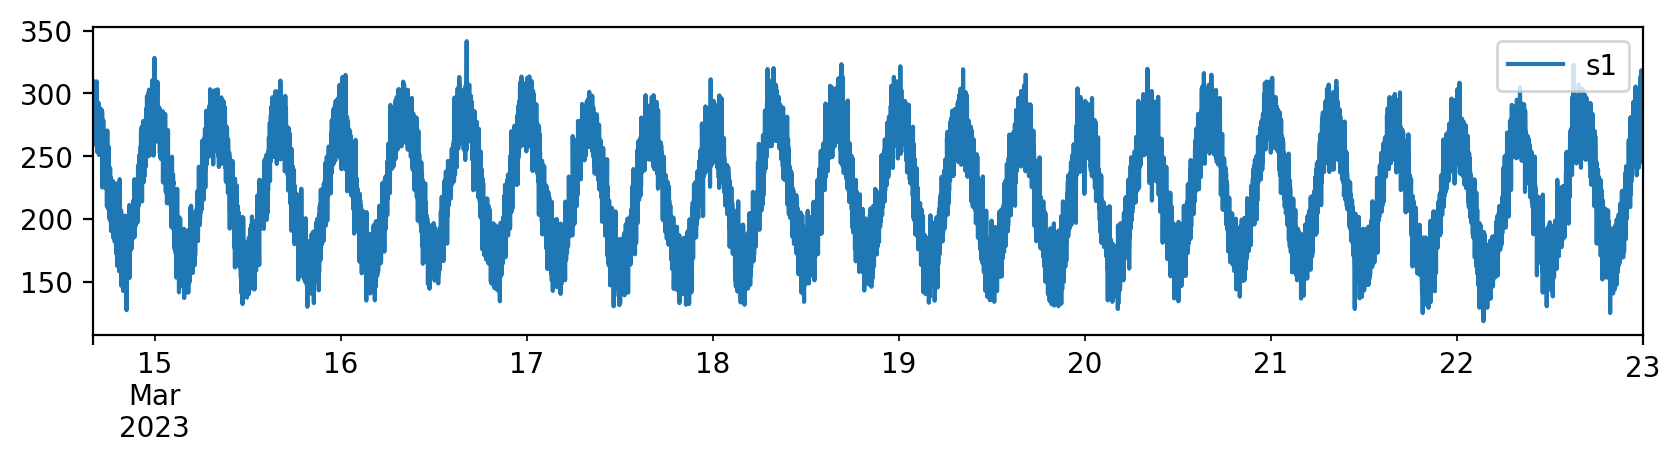

time: 843 ms (started: 2023-03-23 15:39:52 -07:00)


In [2]:
from numalogic.synthetic import SyntheticTSGenerator
from numalogic.synthetic import AnomalyGenerator

ts_generator = SyntheticTSGenerator(
    seq_len=12000,
    num_series=1,
    freq="T",
    primary_period=480,
    secondary_period=3000,
    seasonal_ts_prob=1.0,
    baseline_range=(200.0, 350.0),
    slope_range=(-0.001, 0.01),
    amplitude_range=(10, 75),
    cosine_ratio_range=(0.5, 0.9),
    noise_range=(10, 15),
)
ts_df = ts_generator.gen_tseries()
ts_df.plot()

### Divide into train, test and validation set

In [3]:
train_df, test_df = ts_generator.train_test_split(ts_df, test_size=2400)
train_df, val_df = ts_generator.train_test_split(train_df, test_size=2000)
train_df.shape, val_df.shape, test_df.shape

((7600, 1), (2000, 1), (2400, 1))

time: 4.3 ms (started: 2023-03-23 15:40:40 -07:00)


### Inject synthetic anomalies in the test data
Let's generate a contextual anomaly with a low impact.


In [8]:
anomaly_generator = AnomalyGenerator(
    train_df, anomaly_type="contextual", anomaly_ratio=0.2
)
outlier_test_df = anomaly_generator.inject_anomalies(test_df, cols=["s1"], impact=0.5)

time: 5.84 ms (started: 2023-03-23 15:41:39 -07:00)


<Axes: >

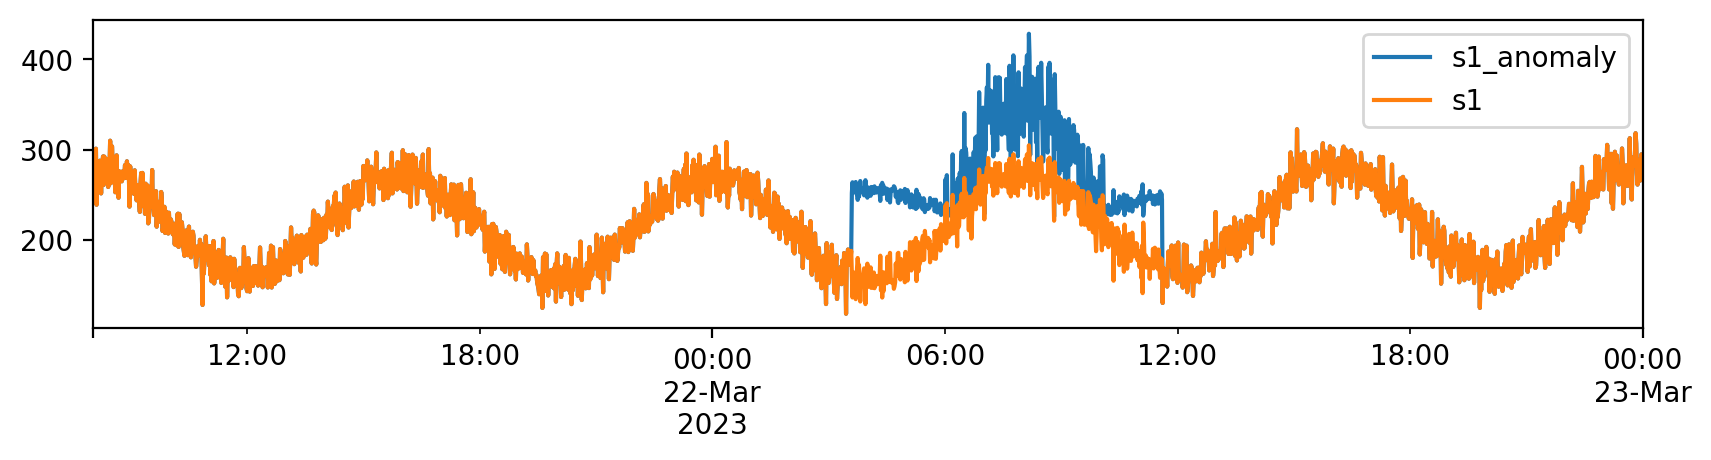

time: 147 ms (started: 2023-03-23 15:41:40 -07:00)


In [9]:
outlier_test_df.rename(columns={"s1": "s1_anomaly"}, inplace=True)
fig, ax = plt.subplots()
outlier_test_df[["s1_anomaly"]].plot(ax=ax)
test_df.plot(ax=ax)

### Preprocess the data
We will use the Tanh scaler here from numalogic.

In [11]:
from numalogic.preprocess import TanhScaler

scaler = TanhScaler()
x_train = scaler.fit_transform(train_df.to_numpy())
x_val = scaler.transform(val_df.to_numpy())
x_test = scaler.transform(outlier_test_df[["s1_anomaly"]].to_numpy())
x_test_good = scaler.transform(test_df.to_numpy())

time: 5.39 ms (started: 2023-03-23 15:46:06 -07:00)


### Define model training parameters
First, we will prepare some torch datasets

In [12]:
from numalogic.tools.data import StreamingDataset
from torch.utils.data import DataLoader


SEQ_LEN = 12
BATCH_SIZE = 64
MAX_EPOCHS = 40

train_dataset = StreamingDataset(x_train, seq_len=SEQ_LEN)
val_dataset = StreamingDataset(x_val, seq_len=SEQ_LEN)
test_dataset = StreamingDataset(x_test, seq_len=SEQ_LEN)

time: 2.95 ms (started: 2023-03-23 15:46:08 -07:00)


### Let's define 1st convolutional model

In [14]:
from numalogic.models.autoencoder.variants import Conv1dAE
from numalogic.models.autoencoder import AutoencoderTrainer

model_1 = Conv1dAE(seq_len=SEQ_LEN, in_channels=1, enc_channels=(16, 32, 8), enc_kernel_sizes=3)
print(model_1)

Conv1dAE(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): ConvBlock(
        (conv): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
        (bnorm): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
      )
      (1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): ConvBlock(
        (conv): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
        (bnorm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
      )
      (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Conv1d(32, 8, kernel_size=(3,), stride=(1,), padding=(1,))
      (5): ReLU()
    )
  )
  (decoder): Decoder(
    (decoder): Sequential(
      (0): ConvTransposeBlock(
        (convtranspose): ConvTranspose1d(8, 32, kernel_size=(3,), stride=(1,), padding=(1,))
        (bnorm): BatchN

In [15]:
trainer = AutoencoderTrainer(max_epochs=MAX_EPOCHS, enable_progress_bar=True)
trainer.fit(model_1, train_dataloaders=DataLoader(train_dataset, batch_size=BATCH_SIZE))

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
2023-03-23 16:29:18,801 - INFO - epoch 0, loss: 0.00871
2023-03-23 16:29:31,898 - INFO - epoch 5, loss: 0.00431
2023-03-23 16:29:43,564 - INFO - epoch 10, loss: 0.00312
2023-03-23 16:29:55,660 - INFO - epoch 15, loss: 0.00195
2023-03-23 16:30:07,282 - INFO - epoch 20, loss: 0.00157
2023-03-23 16:30:19,312 - INFO - epoch 25, loss: 0.00144
2023-03-23 16:30:30,524 - INFO - epoch 30, loss: 0.00137
2023-03-23 16:30:41,862 - INFO - epoch 35, loss: 0.00132
`Trainer.fit` stopped: `max_epochs=40` reached.


time: 1min 35s (started: 2023-03-23 16:29:15 -07:00)


### Fetch the reconstruction error for model 1

In [16]:
train_reconerr_1 = trainer.predict(
    model_1, dataloaders=DataLoader(train_dataset, batch_size=BATCH_SIZE)
).numpy()
val_reconerr_1 = trainer.predict(
    model_1, dataloaders=DataLoader(val_dataset, batch_size=BATCH_SIZE)
).numpy()
test_reconerr_1 = trainer.predict(
    model_1, dataloaders=DataLoader(test_dataset, batch_size=BATCH_SIZE)
).numpy()

time: 383 ms (started: 2023-03-23 16:52:46 -07:00)


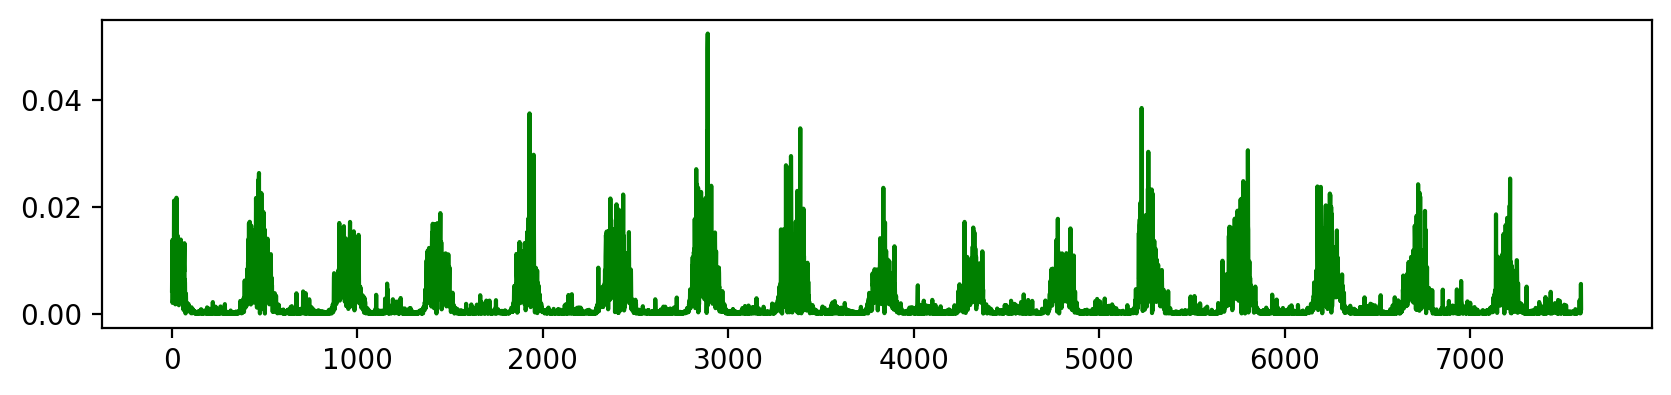

time: 110 ms (started: 2023-03-23 16:52:56 -07:00)


In [18]:
fig = plt.plot(train_reconerr_1, color="g")

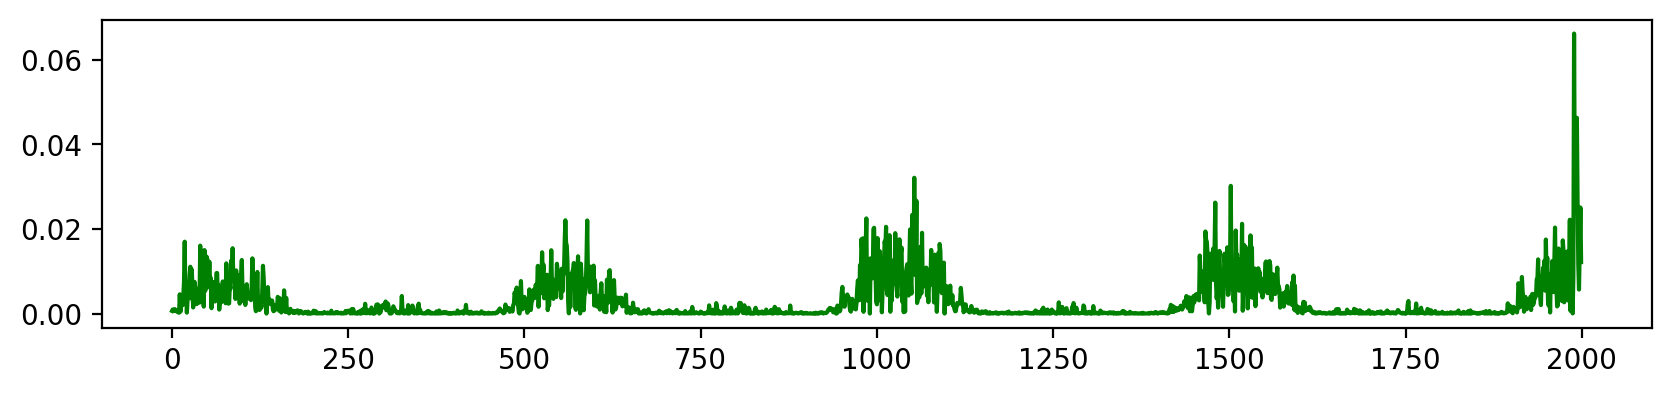

time: 99 ms (started: 2023-03-23 16:53:03 -07:00)


In [19]:
fig = plt.plot(val_reconerr_1, color="g")

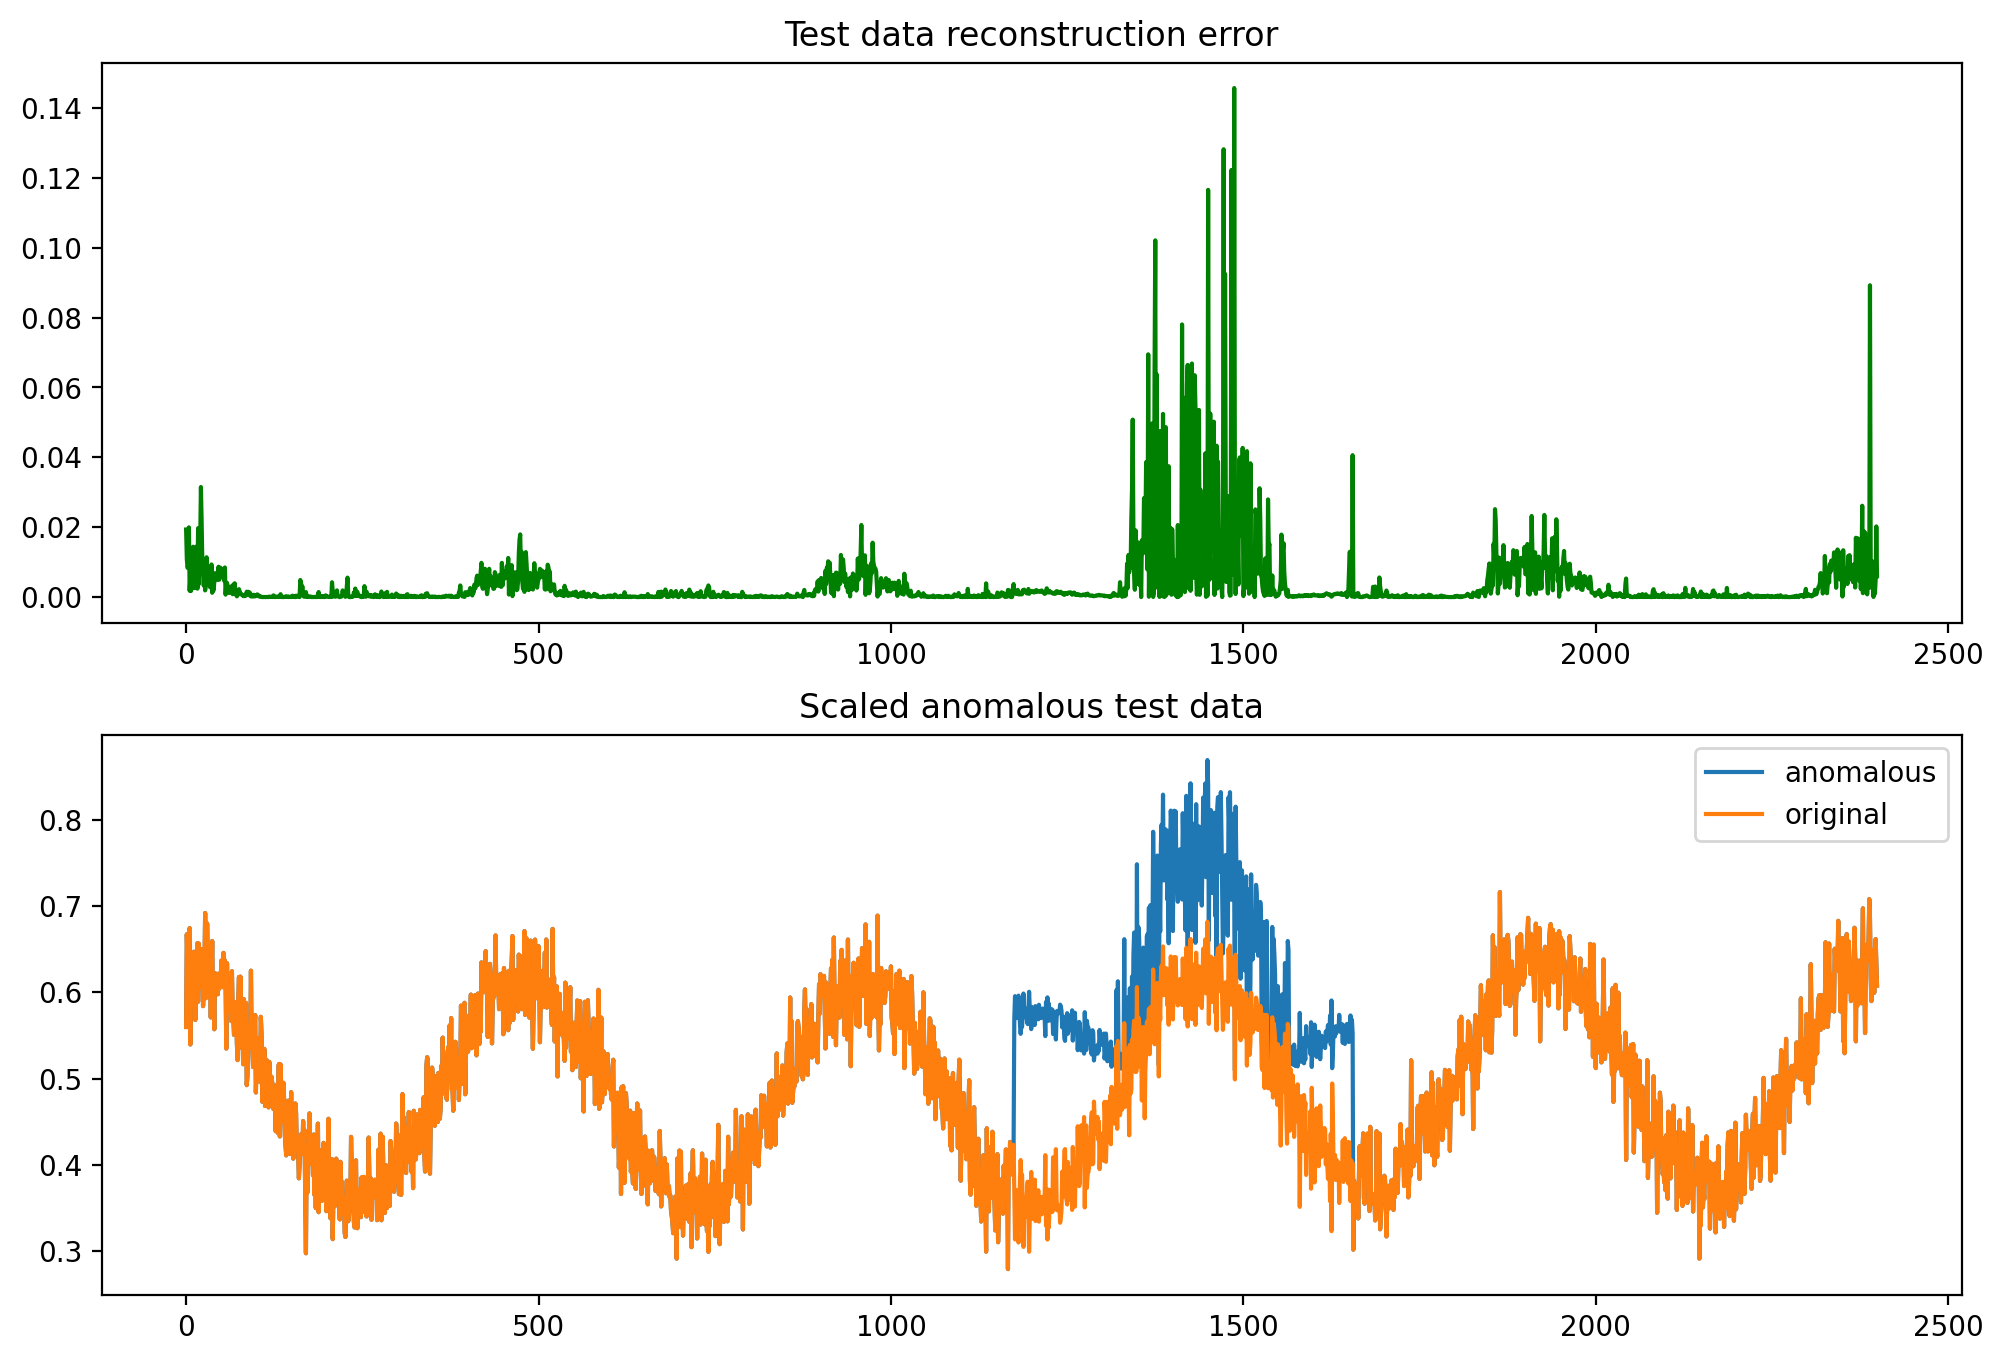

time: 363 ms (started: 2023-03-23 16:53:15 -07:00)


In [20]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
axes[0].set_title("Test data reconstruction error")
axes[1].set_title("Scaled anomalous test data")
_ = axes[0].plot(test_reconerr_1, color="g")
_ = axes[1].plot(x_test, label="anomalous")
_ = axes[1].plot(x_test_good, label="original")
plt.legend()

## Model 2
Using a 2 conv layer network in the encoder and decoder, along with sigmoid activation function,

In [26]:
model_2 = Conv1dAE(seq_len=SEQ_LEN, in_channels=1, enc_channels=(16, 8), enc_kernel_sizes=(5, 3), dec_activation="sigmoid")
model_2

Conv1dAE(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): ConvBlock(
        (conv): Conv1d(1, 16, kernel_size=(5,), stride=(1,), padding=(1,))
        (bnorm): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
      )
      (1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): Conv1d(16, 8, kernel_size=(3,), stride=(1,), padding=(1,))
      (3): ReLU()
    )
  )
  (decoder): Decoder(
    (decoder): Sequential(
      (0): ConvTransposeBlock(
        (convtranspose): ConvTranspose1d(8, 16, kernel_size=(3,), stride=(1,), padding=(1,))
        (bnorm): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
      )
      (1): Upsample(scale_factor=2.0, mode=linear)
      (2): ConvTranspose1d(16, 1, kernel_size=(5,), stride=(1,), padding=(1,))
      (3): Sigmoid()
    )
  )
)

time: 6.93 ms (started: 2023-03-23 17:00:04 -07:00)


In [21]:
trainer = AutoencoderTrainer(max_epochs=MAX_EPOCHS, enable_progress_bar=True)
trainer.fit(model_2, train_dataloaders=DataLoader(train_dataset, batch_size=BATCH_SIZE))

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
2023-03-23 16:55:43,479 - INFO - epoch 0, loss: 0.00502
2023-03-23 16:55:50,884 - INFO - epoch 5, loss: 0.00382
2023-03-23 16:55:58,375 - INFO - epoch 10, loss: 0.00331
2023-03-23 16:56:04,973 - INFO - epoch 15, loss: 0.00252
2023-03-23 16:56:11,568 - INFO - epoch 20, loss: 0.00183
2023-03-23 16:56:19,990 - INFO - epoch 25, loss: 0.00144
2023-03-23 16:56:27,092 - INFO - epoch 30, loss: 0.00125
2023-03-23 16:56:33,675 - INFO - epoch 35, loss: 0.00114
`Trainer.fit` stopped: `max_epochs=40` reached.


time: 58.3 s (started: 2023-03-23 16:55:41 -07:00)


In [22]:
train_reconerr_2 = trainer.predict(
    model_2, dataloaders=DataLoader(train_dataset, batch_size=BATCH_SIZE)
).numpy()
val_reconerr_2 = trainer.predict(
    model_2, dataloaders=DataLoader(val_dataset, batch_size=BATCH_SIZE)
).numpy()
test_reconerr_2 = trainer.predict(
    model_2, dataloaders=DataLoader(test_dataset, batch_size=BATCH_SIZE)
).numpy()

time: 209 ms (started: 2023-03-23 16:58:40 -07:00)


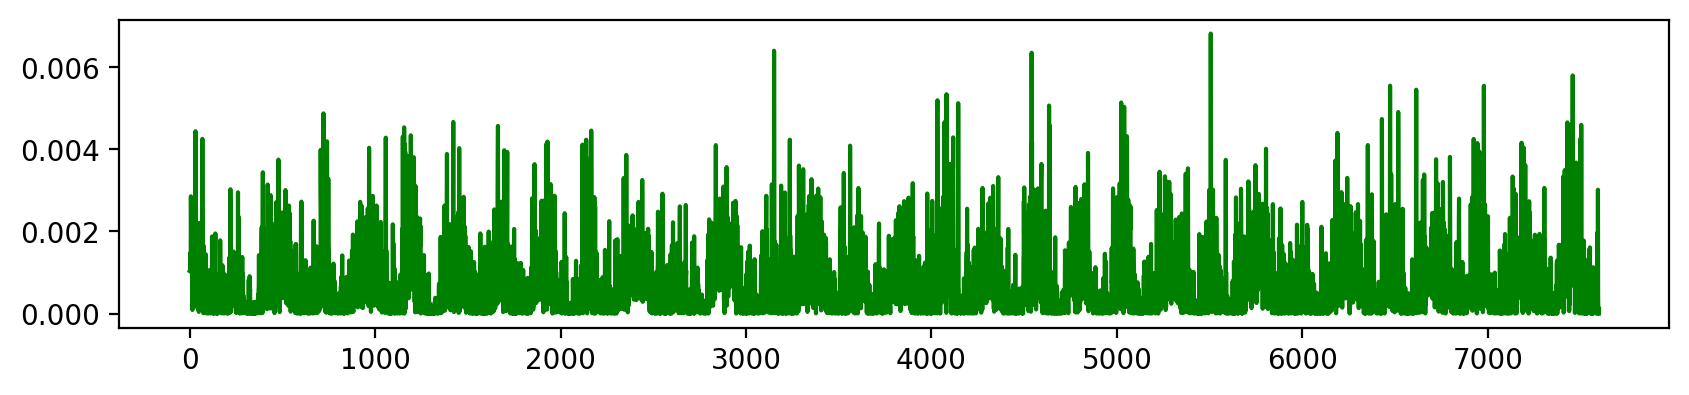

time: 140 ms (started: 2023-03-23 16:58:45 -07:00)


In [23]:
fig = plt.plot(train_reconerr_2, color="g")

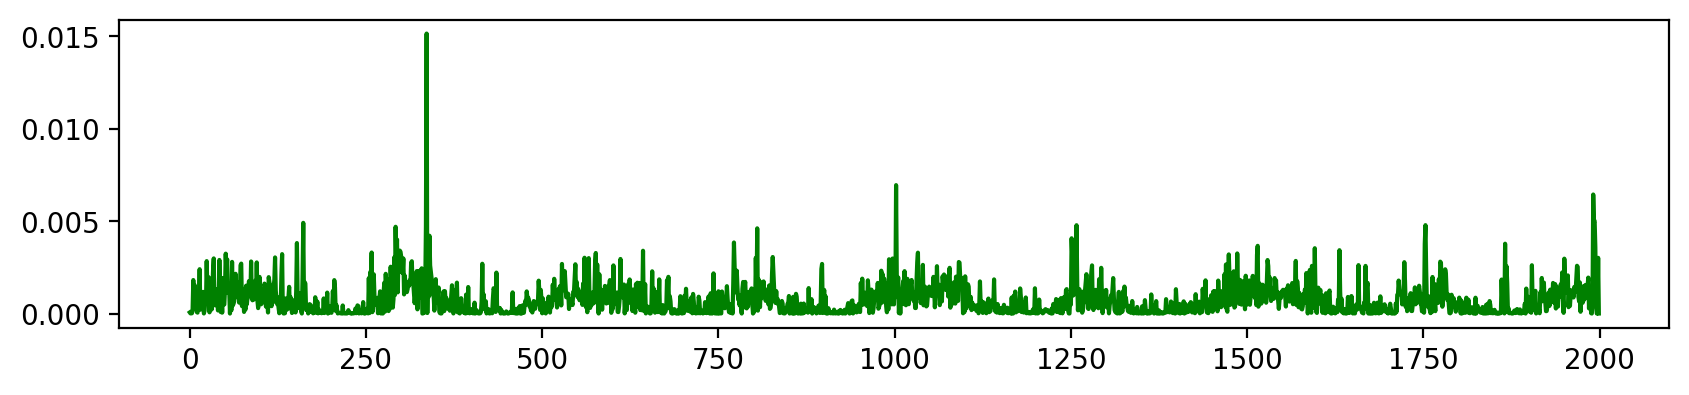

time: 103 ms (started: 2023-03-23 16:58:49 -07:00)


In [24]:
fig = plt.plot(val_reconerr_2, color="g")

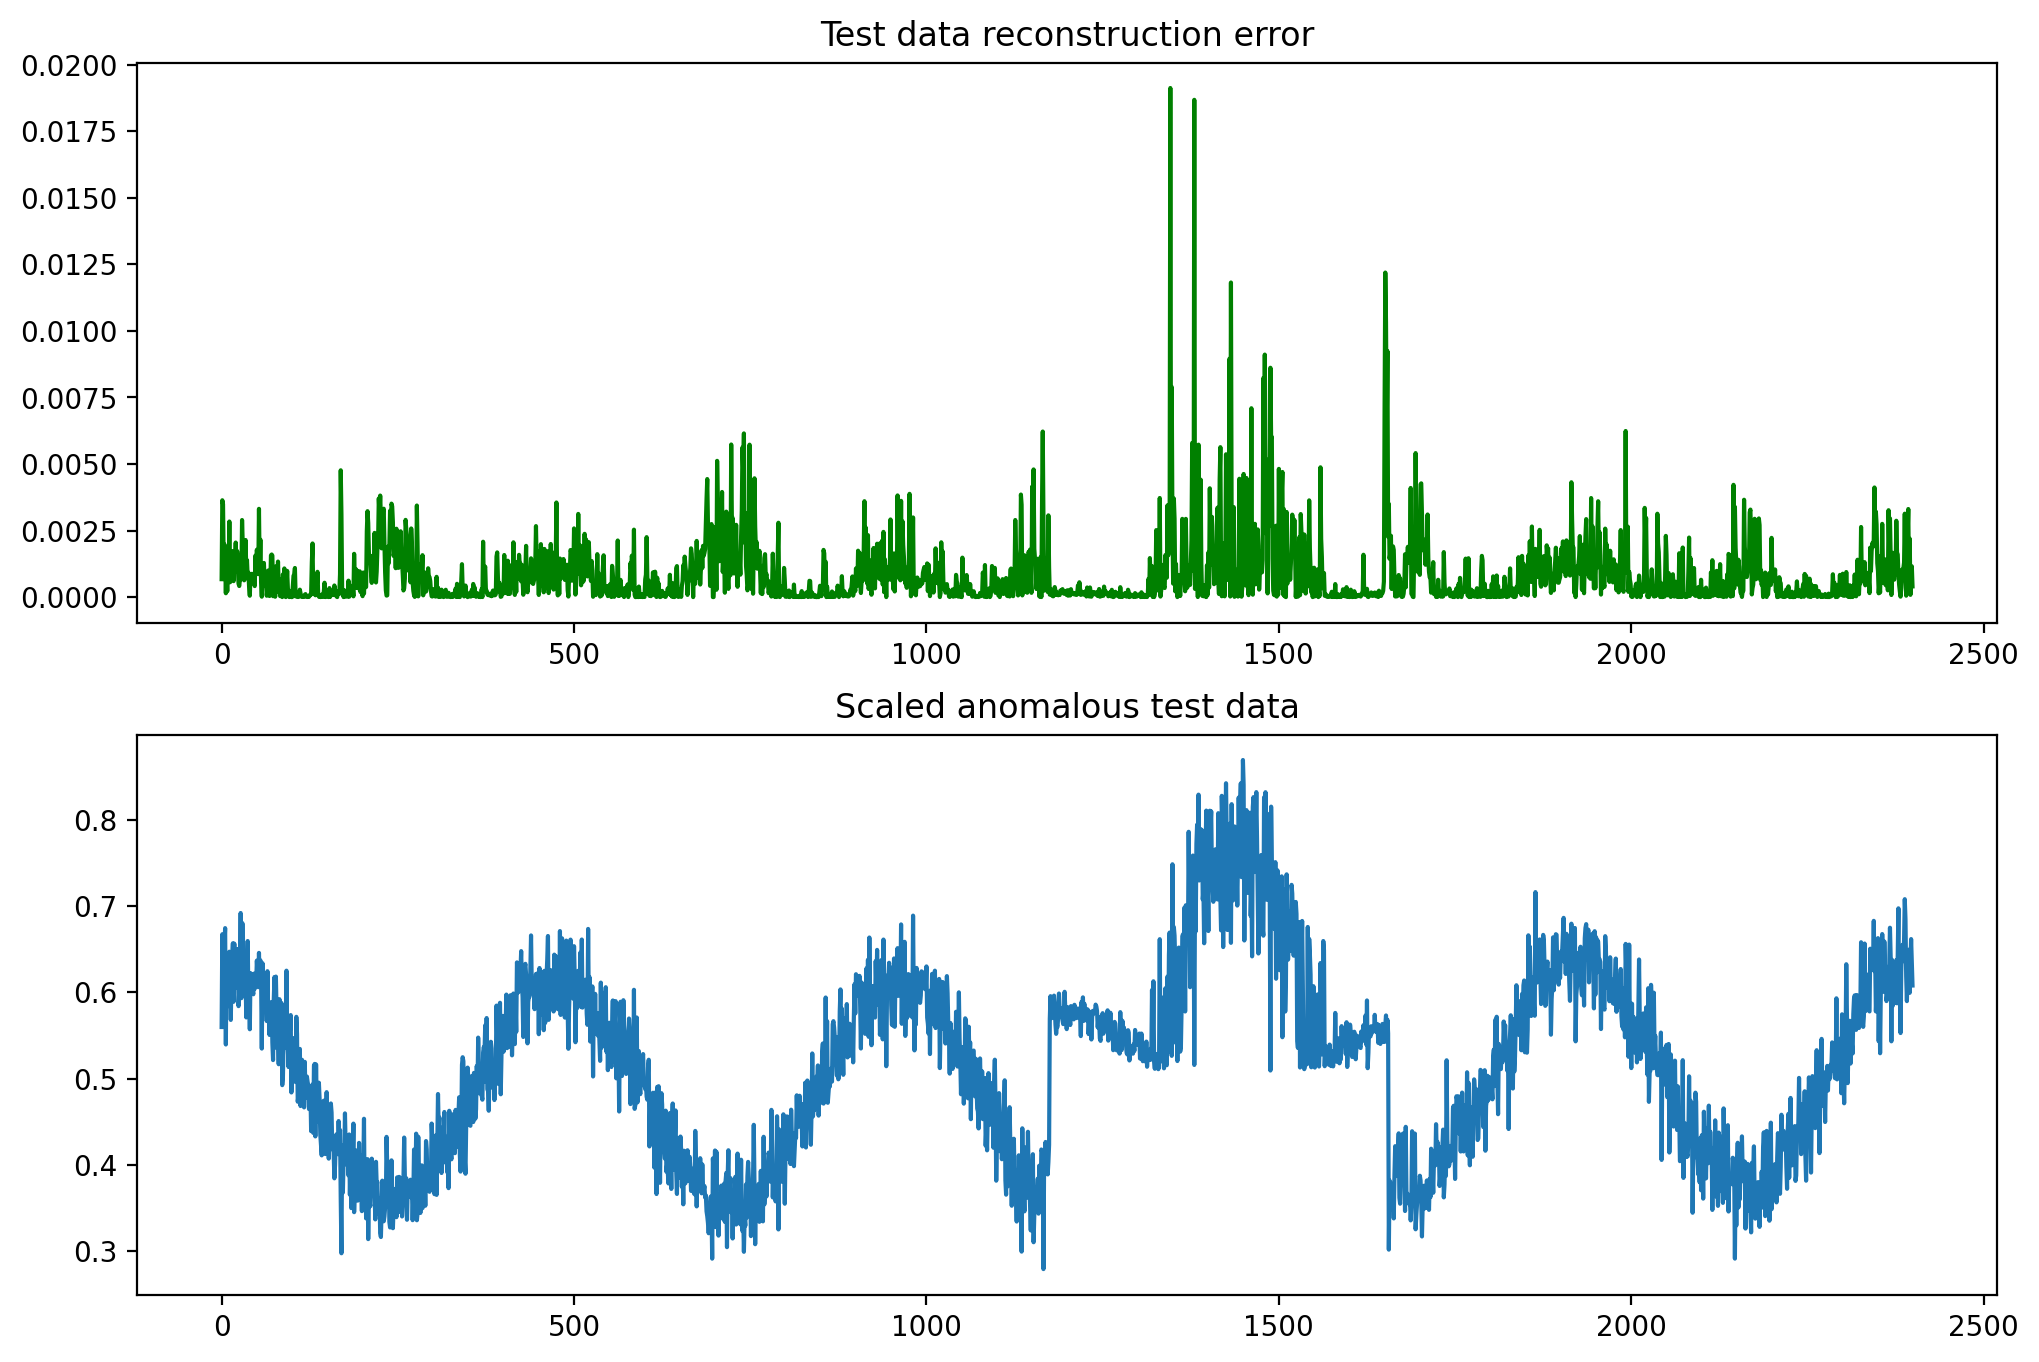

time: 339 ms (started: 2023-03-23 16:58:56 -07:00)


In [25]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
axes[0].set_title("Test data reconstruction error")
axes[1].set_title("Scaled anomalous test data")
_ = axes[0].plot(test_reconerr_2, color="g")
_ = axes[1].plot(x_test)

## Model 3
Using a similar architecture as model 2, but changing the number of filters/channels.

In [65]:
# with upsampling
model_3 = Conv1dAE(seq_len=SEQ_LEN, in_channels=1, enc_channels=[32, 4], enc_kernel_sizes=3)
model_3

Conv1dAE(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): ConvBlock(
        (conv): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
        (bnorm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
      )
      (1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): Conv1d(32, 4, kernel_size=(3,), stride=(1,), padding=(1,))
      (3): ReLU()
    )
  )
  (decoder): Decoder(
    (decoder): Sequential(
      (0): ConvTransposeBlock(
        (convtranspose): ConvTranspose1d(4, 32, kernel_size=(3,), stride=(1,), padding=(1,))
        (bnorm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
      )
      (1): Upsample(scale_factor=2.0, mode=linear)
      (2): ConvTranspose1d(32, 1, kernel_size=(3,), stride=(1,), padding=(1,))
    )
  )
)

time: 5.9 ms (started: 2023-03-23 17:16:57 -07:00)


In [55]:

trainer = AutoencoderTrainer(accelerator="cpu", max_epochs=MAX_EPOCHS, enable_progress_bar=True)
trainer.fit(model_3, train_dataloaders=DataLoader(StreamingDataset(x_train, seq_len=SEQ_LEN), batch_size=BATCH_SIZE))

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
2023-03-23 17:12:18,671 - INFO - epoch 0, loss: 0.0131
2023-03-23 17:12:25,230 - INFO - epoch 5, loss: 0.00458
2023-03-23 17:12:32,307 - INFO - epoch 10, loss: 0.00306
2023-03-23 17:12:39,164 - INFO - epoch 15, loss: 0.00178
2023-03-23 17:12:45,623 - INFO - epoch 20, loss: 0.00137
2023-03-23 17:12:52,097 - INFO - epoch 25, loss: 0.00117
2023-03-23 17:12:58,497 - INFO - epoch 30, loss: 0.00109
2023-03-23 17:13:04,845 - INFO - epoch 35, loss: 0.00105
`Trainer.fit` stopped: `max_epochs=40` reached.


time: 53.1 s (started: 2023-03-23 17:12:16 -07:00)


In [56]:
train_reconerr_3 = trainer.predict(
    model_3, dataloaders=DataLoader(train_dataset, batch_size=BATCH_SIZE)
).numpy()
val_reconerr_3 = trainer.predict(
    model_3, dataloaders=DataLoader(val_dataset,
                                    batch_size=BATCH_SIZE)
).numpy()
test_reconerr_3 = trainer.predict(
    model_3, dataloaders=DataLoader(test_dataset, batch_size=BATCH_SIZE)
).numpy()

time: 258 ms (started: 2023-03-23 17:13:12 -07:00)


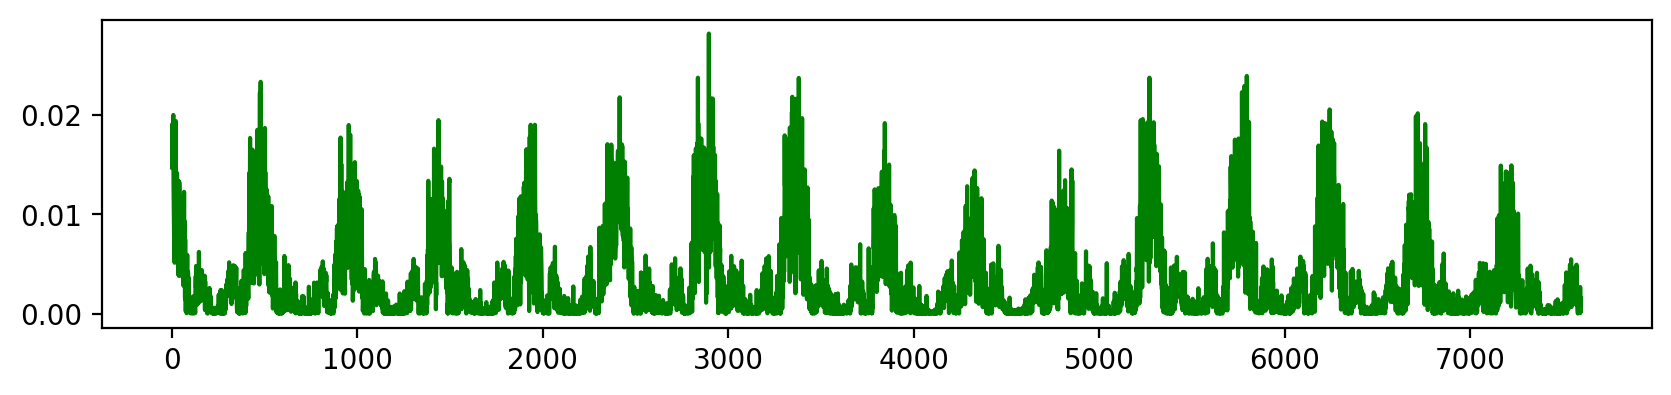

time: 125 ms (started: 2023-03-23 17:13:13 -07:00)


In [57]:
fig = plt.plot(train_reconerr_3, color="g")

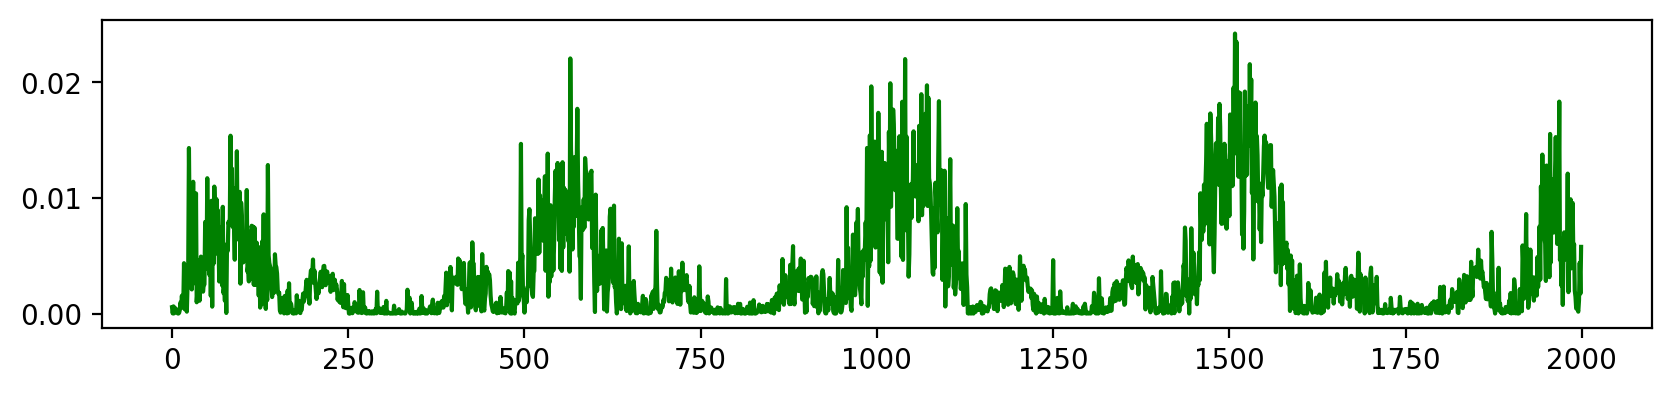

time: 107 ms (started: 2023-03-23 17:13:15 -07:00)


In [58]:
fig = plt.plot(val_reconerr_3, color="g")

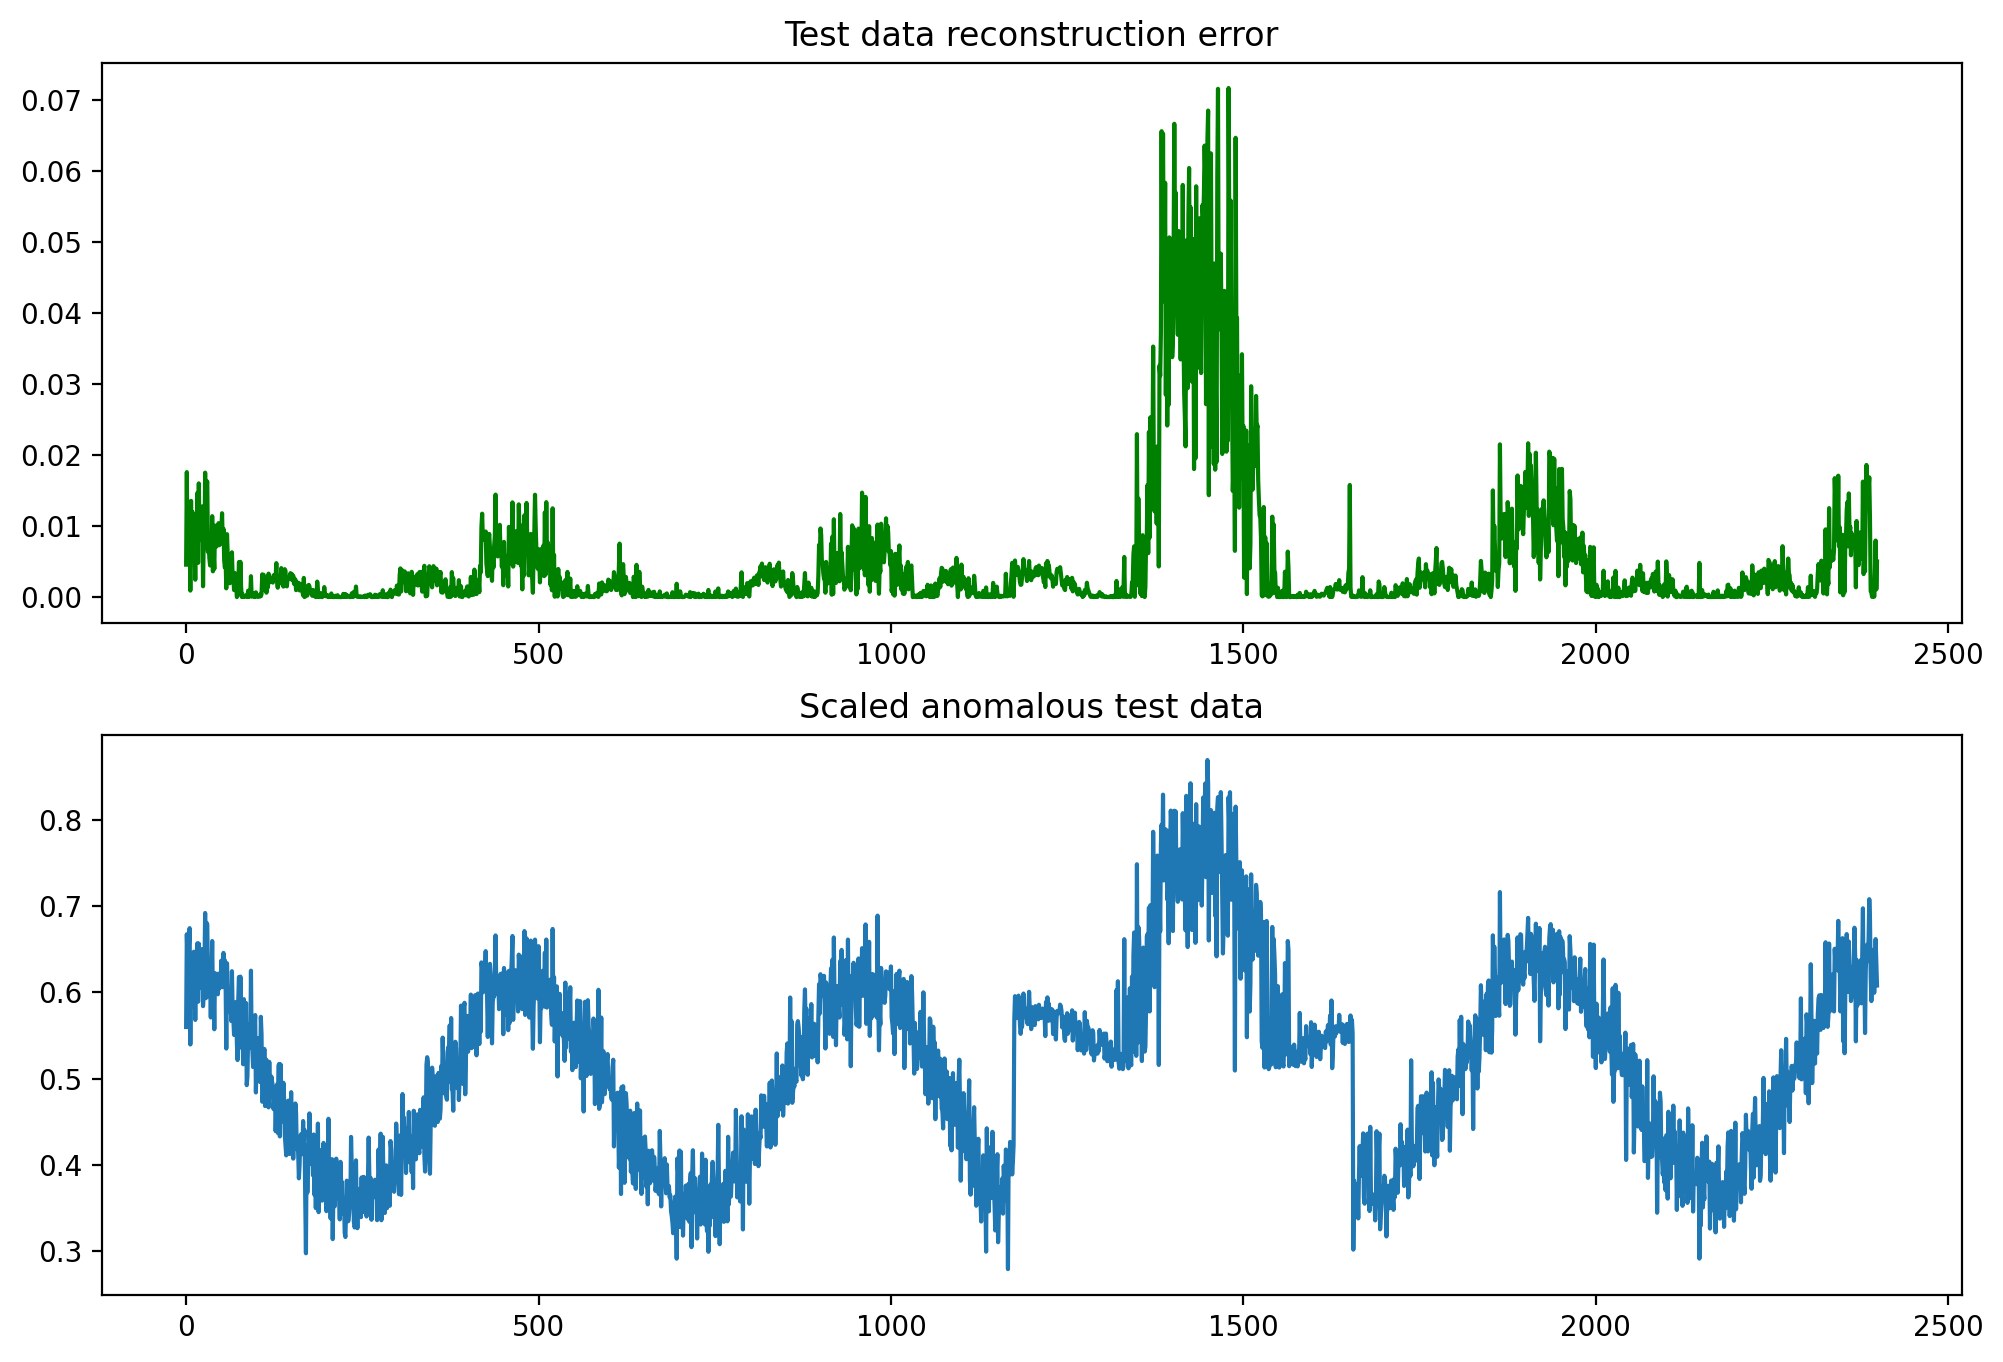

time: 329 ms (started: 2023-03-23 17:13:16 -07:00)


In [59]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
axes[0].set_title("Test data reconstruction error")
# axes[0].set_ylim(0, 0.5)
axes[1].set_title("Scaled anomalous test data")
_ = axes[0].plot(test_reconerr_3, color="g")
_ = axes[1].plot(x_test)

## Comparing the test reconstructions for the different models

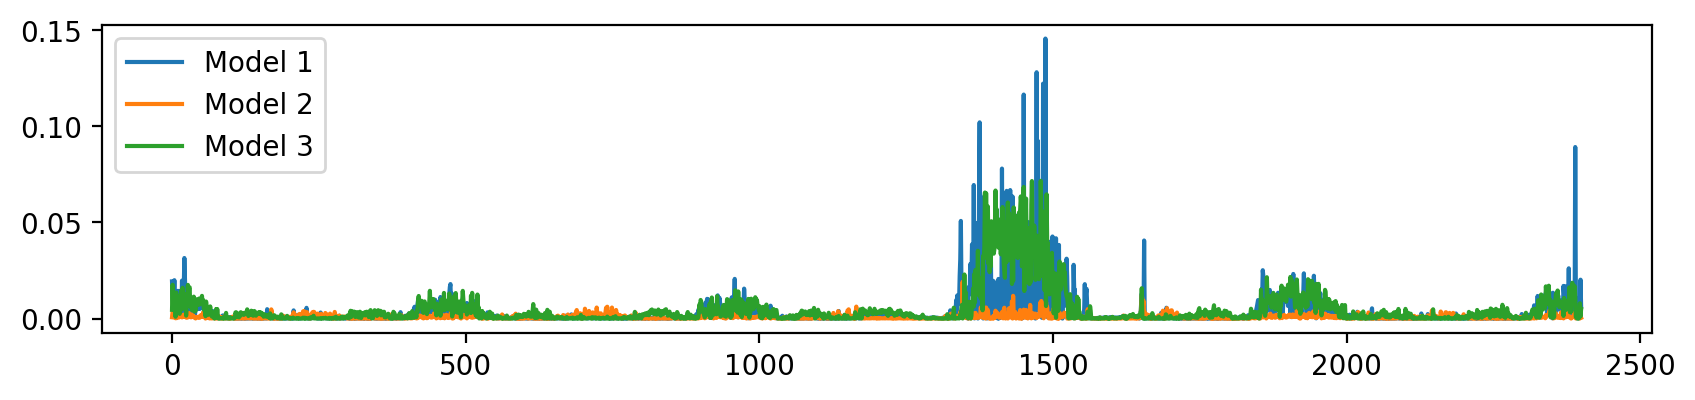

time: 125 ms (started: 2023-03-23 17:16:38 -07:00)


In [64]:
fig, ax = plt.subplots()
ax.plot(test_reconerr_1, label="Model 1")
ax.plot(test_reconerr_2, label="Model 2")
ax.plot(test_reconerr_3, label="Model 3")
plt.legend()